In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('colorblind')
from scipy.stats import entropy
from scipy.spatial.distance import cosine
from itertools import combinations
import datetime
import os
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Potential regression analyses (not here)
- Frames as IVs, activity period as DV (logistic regression)
- Given a bunch of the features we care about as IVs, predict frame use as DV (series of binary logreg)

## Load dataframe

In [2]:
datasheet_file = "/nfs/turbo/si-juliame/social-movements/full_corpus_with_preds_and_stakeholders_08-02-2023.tsv"
df = pd.read_csv(datasheet_file,sep='\t')

In [3]:
df_rel = df[df['Task1:relevance']==1]
df_rel['stance'] = df_rel['Task2:stance'].replace({0:'anti',2:'pro',1:'neutral'})
df_pro = df_rel[df_rel['stance']=='pro']

/tmp/ipykernel_870902/2495673967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel['stance'] = df_rel['Task2:stance'].replace({0:'anti',2:'pro',1:'neutral'})


In [4]:
def redo_tweet_type(row):
    tweet_type = 'broadcast'
    if row['is_quote'] == 1:
        tweet_type = 'quote'
    elif row['is_reply'] == 1:
        tweet_type = 'reply'
    elif row['num_mentions'] >= 1:
        tweet_type = 'mention'
    return tweet_type

In [5]:
#df_rel[(df_rel['num_mentions']>0) & (df_rel['is_reply']==0)]
df_rel['audience'] = df_rel.apply(lambda row: redo_tweet_type(row),axis=1)

/tmp/ipykernel_815845/3383766637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel['audience'] = df_rel.apply(lambda row: redo_tweet_type(row),axis=1)


In [14]:
len(df) # Number of total tweets in the dataset

1852922

In [15]:
len(df_rel) # Number of relevant tweets in the dataset

1480273

In [16]:
df['stakeholder_group'].value_counts()

other         1842359
smo              6029
journalist       4534
Name: stakeholder_group, dtype: int64

In [9]:
for group in df['stakeholder_group'].unique():
    print(f"There are {len(df_rel[df_rel['stakeholder_group']==group])} relevant tweets from the {group} group")

There are 1470238 relevant tweets from the other group
There are 5817 relevant tweets from the smo group
There are 4218 relevant tweets from the journalist group


In [17]:
for group in df['stakeholder_group'].unique():
    print(f"There are {len(df_pro[df_pro['stakeholder_group']==group])} progressive relevant tweets from the {group} group")

There are 723282 progressive relevant tweets from the other group
There are 5273 progressive relevant tweets from the smo group
There are 1895 progressive relevant tweets from the journalist group


In [42]:
def get_counts(df,column_list):
    res = df.groupby(by=column_list).agg('count').reset_index()[column_list + ['tweet_id']]
    if len(column_list) > 1:
        res = res.set_index(column_list[0]).pivot(columns=column_list[1:])
    else:
        res = res.rename(columns={'tweet_id':'count'}).sort_values(by='count')
    return res

In [40]:
get_counts(df_rel,['stakeholder_group'])

,stakeholder_group,count
0,journalist,4218
2,smo,5817
1,other,1470238


In [43]:
get_counts(df_rel,['movement','stakeholder_group'])

tweet_id              
stakeholder_group journalist   other   smo
movement                                  
guns                    1468  554969  3199
immigration             2341  655518  1967
lgbtq                    409  259751   651

In [44]:
get_counts(df_rel,['tweet_type'])

,tweet_type,count
1,directed,44742
2,quote,173115
0,broadcast,626896
3,reply,635520


In [51]:
get_counts(df_rel,['audience'])

,audience,count
2,quote,173115
1,mention,201329
0,broadcast,470309
3,reply,635520


In [3]:
201329+470309

671638

# Rename columns for analysis

In [4]:
frame_names = {
    'Task2:stance':'stance',
    'Task3:diagnostic':'diagnostic',
    'Task3:prognostic':'prognostic',
    'Task5:motivational-elements': 'motivational',
    'Task3:identify': 'identify (diag)',
    'Task3:blame': 'blame (diag)',
    'Task4:solution': 'solution (prog)',
    'Task4:tactics':'tactics (prog)',
    'Task4:solidarity': 'solidarity (prog)',
    'Task4:counter':'counterframing (prog)',
}
macro_frames = ['diagnostic','prognostic','motivational']
frame_elements = ['identify (diag)', 'blame (diag)', 'solution (prog)', 'tactics (prog)', 'solidarity (prog)', 'counterframing (prog)']
all_frames = macro_frames + frame_elements
frame_elem_for_analysis = ['identify (diag)', 'blame (diag)', 'solution (prog)', 'tactics (prog)', 'solidarity (prog)']


In [5]:
df_rel = df_rel.rename(columns={'Task2:stance':'stance'})
df_rel = df_rel.rename(columns=frame_names)
df_rel['stance'] = df_rel['stance'].replace({0:'anti',2:'pro',1:'neutral'})

In [34]:
def add_hatches(g,hatches):
    for ax in g.axes.flat:
        # select the correct patches
        patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
        # the number of patches should be evenly divisible by the number of hatches
        h = hatches * (len(patches) // len(hatches))
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor('none')

In [9]:
results_dir = '/home/juliame/social-movements/results/'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

# Frame distributions across movements (all stances)

In [96]:
df_mvmt = df_rel[['movement']+all_frames].groupby(by=['movement']).agg('sum').reset_index().melt(id_vars='movement')
df_mvmt.columns = ['movement','category','frequency']
df_mvmt = df_mvmt.set_index('category').pivot(columns='movement').reindex(all_frames)
df_mvmt

frequency                    
movement                   guns immigration   lgbtq
category                                           
diagnostic               367477      515519  123259
prognostic               310409      309783  126599
motivational              94442       80876   36047
identify (diag)          310681      481970  118948
blame (diag)             249253      373184   48818
solution (prog)          111491      205901   17699
tactics (prog)           141586       56996   23684
solidarity (prog)         42344       25343   82994
counterframing (prog)     59680       48501    7500

In [19]:
df_mvmt = df_rel[['movement']+all_frames].groupby(by=['movement']).agg('mean').reset_index().melt(id_vars='movement')
df_mvmt.columns = ['movement','category','frequency']
df_mvmt.set_index('category').pivot(columns='movement').reindex(all_frames).round(3)
#Frame frequencies across movements.

frequency                   
movement                   guns immigration  lgbtq
category                                          
diagnostic                0.657       0.781  0.473
prognostic                0.555       0.469  0.485
motivational              0.169       0.123  0.138
identify (diag)           0.555       0.730  0.456
blame (diag)              0.445       0.566  0.187
solution (prog)           0.199       0.312  0.068
tactics (prog)            0.253       0.086  0.091
solidarity (prog)         0.076       0.038  0.318
counterframing (prog)     0.107       0.074  0.029

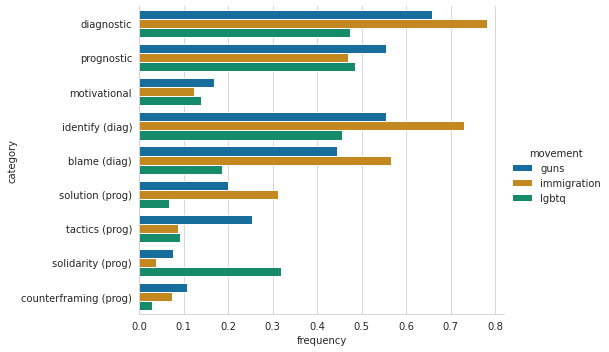

In [20]:
sns.catplot(x='frequency',y='category',hue='movement',
            data=df_mvmt,kind='bar',aspect=1.5)
#Plot of the above table. we see diagnostic framing is most prevalent for immigration, 
# Compared to the other movements, immigration tweets most frequently use diagnostic frames and solution (prognostic)
# Gun-related tweets focus more on tactics and counterframing (prognostic categories) relative to other movements
# LGBTQ tweets use the solidarity frame far more than the other two movements (happy pride counts)

In [25]:
df_mvmt_ci = df_rel[['movement']+all_frames].melt(id_vars='movement')
df_mvmt_ci.columns = ['movement','category','frequency']

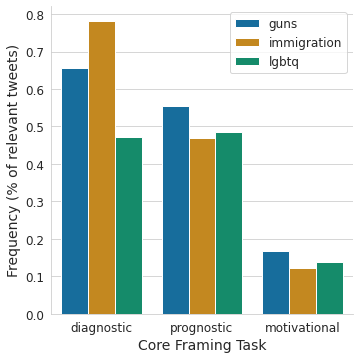

In [72]:
g = sns.catplot(y='frequency',x='category',hue='movement',
            data=df_mvmt[df_mvmt['category'].isin(macro_frames)],kind='bar',aspect=1,legend=False)

plt.xlabel('Core Framing Task',fontsize=14)
plt.ylabel('Frequency (% of relevant tweets)',fontsize=14)
plt.legend(fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)

plt.savefig(os.path.join(results_dir,'macro-frame-across-movements.pdf'),bbox_inches='tight')

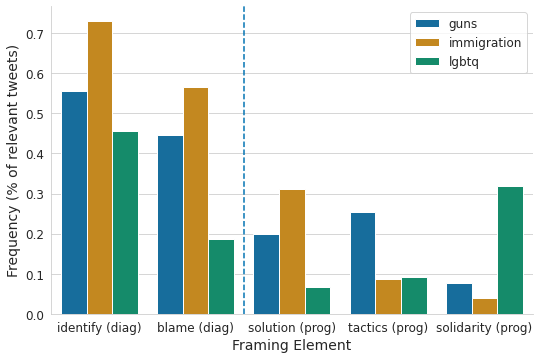

In [82]:
g = sns.catplot(y='frequency',x='category',hue='movement',
            data=df_mvmt[df_mvmt['category'].isin(frame_elem_for_analysis)],kind='bar',aspect=1.5,legend=False)

plt.xlabel('Framing Element',fontsize=14)
plt.ylabel('Frequency (% of relevant tweets)',fontsize=14)
plt.legend(fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axvline(1.5,linestyle='--')
plt.savefig(os.path.join(results_dir,'frame-elements-across-movements.pdf'),bbox_inches='tight')

In [111]:
df_rel[all_frames].mean().round(3)*100
# Overall frame frequencies (percentage of relevant tweets containing each frame. multiple frames may appear in a message, so does not sum to 1)

diagnostic               68.0
prognostic               50.4
motivational             14.3
identify (diag)          61.6
blame (diag)             45.3
solution (prog)          22.6
tactics (prog)           15.0
solidarity (prog)        10.2
counterframing (prog)     7.8
dtype: float64

# Frame distributions movement/counter (guns and immigration only)


In [11]:
df_sub = df_rel[['movement','stance']+macro_frames+frame_elem_for_analysis].groupby(by=['movement','stance']).agg('mean').reset_index()
#df_sub = df_sub[df_sub['stance']!='neutral']
df_sub = pd.melt(df_sub,id_vars=['movement','stance'])
df_sub.columns=['movement','stance','frame','frequency']
df_sub = df_sub[df_sub['movement']!='lgbtq'] #performance not good enough for other categories
df_sub = df_sub[df_sub['stance']!='neutral']

In [100]:
import numpy as np

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.5803921568627451, 0.5803921568627451, 0.5803921568627451), (0.9254901960784314, 0.8823529411764706, 0.2), (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]


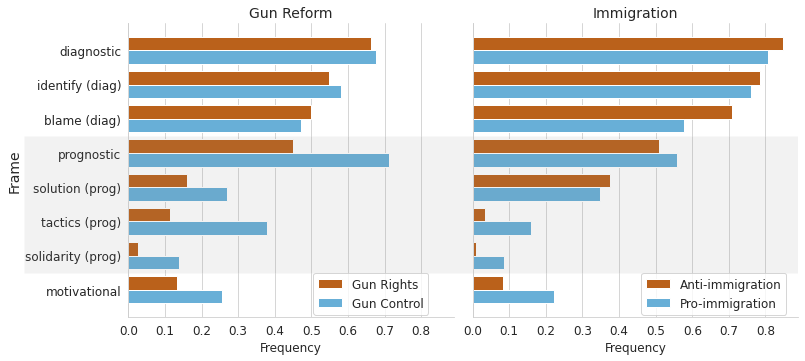

In [115]:
frame_order = ['diagnostic','identify (diag)','blame (diag)',
               'prognostic','solution (prog)','tactics (prog)','solidarity (prog)','motivational']
pal = sns.color_palette('colorblind')
print(color_order)
g = sns.catplot(x='frequency',y='frame',hue='stance',col='movement',data=df_sub,kind='bar',
                aspect=1.1,order=frame_order,legend=False,palette = [pal[3],pal[-1]])

ax0,ax1 = g.axes.flat
ax0.set_title('Gun Reform',fontsize=14)
ax1.set_title('Immigration',fontsize=14)
ax0.set_xlabel('Frequency',fontsize=12)
ax1.set_xlabel('Frequency',fontsize=12)
ax0.set_ylabel('Frame',fontsize=14)


ax0.axhspan(2.5,6.5,facecolor='gray',alpha=0.1,clip_on=False,xmin=-.32,xmax=1.3)
ax1.axhspan(2.5,6.5,facecolor='gray',alpha=0.1)

ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)

L0 = ax0.legend(bbox_to_anchor=(0.55,0.17),fontsize=12)
L1 = ax1.legend(bbox_to_anchor=(0.5,0.17),fontsize=12)

L0.get_texts()[0].set_text('Gun Rights')
L0.get_texts()[1].set_text('Gun Control')
L1.get_texts()[0].set_text('Anti-immigration')
L1.get_texts()[1].set_text('Pro-immigration')


plt.savefig(os.path.join(results_dir,'pro_vs_anti.pdf'),bbox_inches='tight')

# For guns, similar overall rate of diagnostic framing, although the "pro" side uses more problem identification while the "anti" side uses more blame
# For immigration, anti side uses slightly more diagnostic framing, especially for blame. 
# Pro side uses more prognostic framing for both, especially for tactics and solidarity. 
# For solution, pro side uses more in guns, but anti side uses more in immigration
# Anti does more counterframing which makes sense given that they are the countermovements, but giant caveat that our model sucks
# I want some way of testing if the frame distribution is more similar within movement on opposite sides, vs same side of different movements. What's the best way to test that? 

In [32]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [116]:
#Pairwise Entropy calculation with frequencies over these 9 categories
df_sub = df_rel[['movement','stance']+all_frames].groupby(by=['movement','stance']).agg('mean').reset_index()
df_sub = df_sub[df_sub['movement']!='lgbtq'] #performance not good enough for other categories
df_sub = df_sub[df_sub['stance']!='neutral']
frequency_vectors = df_sub[frame_elements+['motivational']].values.tolist()
df_sub['subset'] = df_sub[['movement','stance']].agg('-'.join, axis=1)
df_sub['vector'] = frequency_vectors

In [125]:
df_rel[df_rel]

,tweet_id,text_x,Task1:relevance,stance,diagnostic,prognostic,Task5:motivational-macro,identify (diag),blame (diag),solution (prog),...,num_mentions,num_hashtags,begins_with_mention,tweet_type,movement,month,protest_activity,filename,stakeholder_group,audience
1,1006645607270936577,https://t.co/6d3Ih4lHX3 : Marching to end gun ...,1,pro,0,1,0,0,0,0,...,0,0,0,broadcast,guns,2018_06,avg,/nfs/turbo/si-juliame/social-movements/bozarth...,other,broadcast
5,1006645814905704450,"""@Spartan_155D @SenSanders Again, we have tons...",1,pro,1,1,0,1,0,0,...,2,0,1,reply,guns,2018_06,avg,/nfs/turbo/si-juliame/social-movements/bozarth...,other,reply
6,1006645895444815873,"""@justmy_luck @chelenki @GunOwners No. #2A con...",1,anti,0,1,0,0,0,0,...,3,1,1,reply,guns,2018_06,avg,/nfs/turbo/si-juliame/social-movements/bozarth...,other,reply
10,1006646203277291522,This should be an eye opener for All Law abidi...,1,anti,1,1,0,1,1,0,...,0,8,0,reply,guns,2018_06,avg,/nfs/turbo/si-juliame/social-movements/bozarth...,other,reply
11,1006646232654151685,"Ware Orange, Against Gun Violence!!! https://t...",1,pro,0,1,0,0,0,0,...,0,0,0,broadcast,guns,2018_06,avg,/nfs/turbo/si-juliame/social-movements/bozarth...,other,broadcast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852917,970162555795644416,@SRuhle @realDonaldTrump The only number he ca...,1,pro,1,0,0,1,1,0,...,2,0,1,reply,guns,2018_03,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,reply
1852918,970162671977873413,@BryanDawsonUSA @JohnOSullivan36 And the NRA a...,1,pro,1,0,0,1,1,0,...,2,0,1,reply,guns,2018_03,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,reply
1852919,970162675748560897,@marcorubio MAYBE YOU ALL AGREE but that crazy...,1,pro,1,0,1,0,1,1,...,1,0,1,reply,guns,2018_03,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,reply
1852920,970162702181109760,I'm raising money to Support #teenactivist. Th...,1,pro,0,1,1,0,0,0,...,1,3,0,broadcast,guns,2018_03,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,mention


In [128]:
df_rel[(df_rel['movement']==movement) & (df_rel['stance']==stance)]

,tweet_id,text_x,Task1:relevance,stance,diagnostic,prognostic,Task5:motivational-macro,identify (diag),blame (diag),solution (prog),...,num_mentions,num_hashtags,begins_with_mention,tweet_type,movement,month,protest_activity,filename,stakeholder_group,audience
261,1006667409716076547,@marcorubio @Twitter @ChickfilA @CBSMoneyWatch...,1,pro,1,0,0,1,1,0,...,4,1,1,reply,immigration,2018_06,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,reply
310,1006670859078176770,Absolutely not. I...we...cannot be silent in ...,1,pro,1,1,0,1,1,0,...,0,1,0,quote,immigration,2018_06,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,quote
440,1006682073002889217,@realDonaldTrump Why didn't you ban bump-stock...,1,pro,1,1,1,1,1,1,...,1,0,1,reply,immigration,2018_06,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,reply
711,1006704129559785472,@GOP @realDonaldTrump By putting #KidsInCages?...,1,pro,1,0,0,1,1,0,...,2,2,1,reply,immigration,2018_06,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,reply
757,1006708010549379078,"#USA, we are feeding the evil wolf inside our ...",1,pro,1,1,1,1,1,1,...,0,10,0,quote,immigration,2018_06,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,quote
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843644,1010774423929057280,"6-24-18 Trump is STILL holding 2,300 kids as h...",1,pro,1,1,1,1,1,0,...,0,2,0,broadcast,immigration,2018_06,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,broadcast
1843649,1010774915950284800,16.#aafaque_ehsens_ideamines_sites #ideamines_...,1,pro,1,1,0,1,0,1,...,0,10,0,broadcast,immigration,2018_06,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,broadcast
1843652,1010775026662948865,#WithRefugees Italian football legends take ...,1,pro,0,1,0,1,0,0,...,0,1,0,broadcast,immigration,2018_06,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,broadcast
1843653,1010775203234934784,Dear @AndrejPlenkovic we're calling on you to ...,1,pro,0,1,1,0,0,1,...,1,2,0,broadcast,immigration,2018_06,high,/nfs/turbo/si-juliame/social-movements/bozarth...,other,mention


In [139]:
# get 1K frequency vectors based on mean of 10K randomly sampled from each of guns-anti,guns-pro,immigration-anti,immigration-pro
# Output structure: movement, stance, sample_id, vector
# for each sample id, calculate jensen-shannon divergence between all pairs
sample_size=10000
num_samples=1000
res = []
for i in range(num_samples):
    for movement in ['immigration','guns']:
        for stance in ['pro','anti']:
            df_sub = df_rel[(df_rel['movement']==movement) & (df_rel['stance']==stance)]
            df_sub = df_sub[['movement','stance']+macro_frames+frame_elem_for_analysis]
            df_sub = df_sub.sample(n=sample_size)
            vec = df_sub[macro_frames+frame_elem_for_analysis].mean().tolist()
            res.append((i,movement+'-'+stance,vec))
res = pd.DataFrame(res,columns=['sample_id','movement-stance','vector'])
            
            

In [147]:
entropies_avg

movement-stance sample_id             entropy          
                                            mean       sem      mean       sem
0                (guns-pro, guns-anti)     499.5  9.133273  0.089789  0.000136
1        (immigration-anti, guns-anti)     499.5  9.133273  0.051740  0.000069
2         (immigration-anti, guns-pro)     499.5  9.133273  0.180120  0.000125
3         (immigration-pro, guns-anti)     499.5  9.133273  0.022045  0.000053
4          (immigration-pro, guns-pro)     499.5  9.133273  0.049169  0.000078
5  (immigration-pro, immigration-anti)     499.5  9.133273  0.097173  0.000153

In [148]:
entropies = []

for i in range(num_samples):
    res_sub = res[res['sample_id']==i]
    for pair in combinations(res_sub['movement-stance'],2):
        vec0 = res_sub[res_sub['movement-stance']==pair[0]]['vector'].tolist()[0]
        vec1 = res_sub[res_sub['movement-stance']==pair[1]]['vector'].tolist()[0]
        ent = entropy(vec0,vec1)
        entropies.append((i,pair,ent))
entropies = pd.DataFrame(entropies,columns=['sample_id','movement-stance','entropy'])
entropies_avg = entropies.groupby(by=['movement-stance'])['entropy'].agg(['mean','sem']).reset_index() 
entropies_avg['ci'] = 1.96*entropies_avg['sem']
entropies_avg['ci_lower'] = entropies_avg['mean'] - entropies_avg['ci']
entropies_avg['ci_upper'] = entropies_avg['mean'] + entropies_avg['ci']

# for each sample_id
# for each movement-stance pair,
#calculate JS divergence
# entropies dataframe: sample_id,movement_stance,entropy
# Get mean entropy by grouping by movement_stance
# Get standard errors by grouping movement_stance (mean, sem), add confint with +-1.96*sem

In [150]:
entropies_avg.sort_values(by='mean')

,movement-stance,mean,sem,ci,ci_lower,ci_upper
3,"(immigration-pro, guns-anti)",0.022045,0.000053,0.000103,0.021942,0.022148
4,"(immigration-pro, guns-pro)",0.049169,0.000078,0.000152,0.049017,0.049321
1,"(immigration-anti, guns-anti)",0.051740,0.000069,0.000136,0.051605,0.051876
0,"(guns-pro, guns-anti)",0.089789,0.000136,0.000267,0.089522,0.090055
5,"(immigration-pro, immigration-anti)",0.097173,0.000153,0.000300,0.096872,0.097473
2,"(immigration-anti, guns-pro)",0.180120,0.000125,0.000246,0.179874,0.180365


In [151]:
res.to_csv(os.path.join(results_dir,'bootstrap_frame_vectors.tsv'),sep='\t')
entropies_avg.to_csv(os.path.join(results_dir,'frame_vector_entropies.tsv'),sep='\t')

In [37]:
entropies = []
pairs = [('guns-anti','guns-pro'),('immigration-anti','immigration-pro'),('guns-anti','immigration-anti'),('guns-pro','immigration-pro')]
for pair in pairs:
    vec0 = df_sub[df_sub['subset']==pair[0]]['vector'].tolist()[0]
    vec1 = df_sub[df_sub['subset']==pair[1]]['vector'].tolist()[0]
    ent = entropy(vec0,vec1)
    cos = cosine(vec0,vec1)
    entropies.append([pair[0],pair[1],ent,cos])
df_ent = pd.DataFrame(entropies)
df_ent.columns=['subset 0','subset 1','entropy','cosine distance']

In [38]:
df_ent#.sort_values(by='entropy')
# Order from most similar (lowest entropy) to least similar with all 9 categories
# 1. gun (pro) and immigration (pro)
# 2. immigration (pro and anti)
# 3. gun (anti) and immigration (anti)
# 4. guns (pro and anti)

# With just DPM frames
# 1. pro (gun and immigration)
# 2. anti (gun and immigration)
# 3. guns (pro and anti)
# 4. immigration (pro and anti)


,subset 0,subset 1,entropy,cosine distance
0,guns-anti,guns-pro,0.140824,0.069148
1,immigration-anti,immigration-pro,0.110584,0.024236
2,guns-anti,immigration-anti,0.119645,0.025768
3,guns-pro,immigration-pro,0.081635,0.044635


# Analysis of protest activity

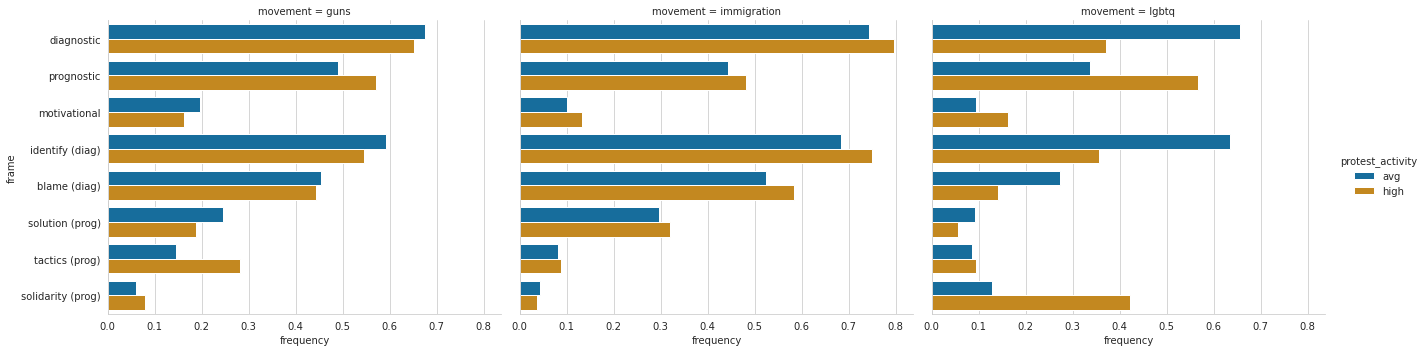

In [154]:
df_act = df_rel[['movement','protest_activity']+macro_frames+frame_elem_for_analysis].groupby(['movement','protest_activity']).agg('mean').reset_index()
df_act = pd.melt(df_act,id_vars=['movement','protest_activity'])
df_act.columns=['movement','protest_activity','frame','frequency']
sns.catplot(x='frequency',y='frame',hue='protest_activity',col='movement',data=df_act,kind='bar',aspect=1.25) 
#This is combined stances (below is just pro), but findings are the same

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.5803921568627451, 0.5803921568627451, 0.5803921568627451), (0.9254901960784314, 0.8823529411764706, 0.2), (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]


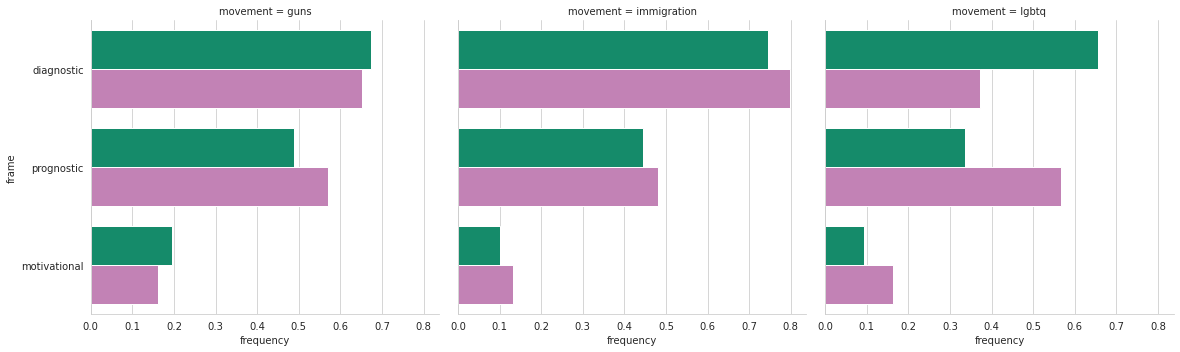

In [158]:
df_act = df_rel[['movement','protest_activity']+macro_frames].groupby(['movement','protest_activity']).agg('mean').reset_index()
df_act = pd.melt(df_act,id_vars=['movement','protest_activity'])
df_act.columns=['movement','protest_activity','frame','frequency']

#frame_order = ['diagnostic','identify (diag)','blame (diag)',
 #              'prognostic','solution (prog)','tactics (prog)','solidarity (prog)','motivational']
pal = sns.color_palette('colorblind')
print(color_order)
g = sns.catplot(x='frequency',y='frame',hue='protest_activity',col='movement',data=df_act,kind='bar',
                aspect=1.1,legend=False,palette = [pal[2],pal[4]])

# ax0,ax1 = g.axes.flat
# ax0.set_title('Gun Reform',fontsize=14)
# ax1.set_title('Immigration',fontsize=14)
# ax0.set_xlabel('Frequency',fontsize=12)
# ax1.set_xlabel('Frequency',fontsize=12)
# ax0.set_ylabel('Frame',fontsize=14)


# ax0.axhspan(2.5,6.5,facecolor='gray',alpha=0.1,clip_on=False,xmin=-.32,xmax=1.3)
# ax1.axhspan(2.5,6.5,facecolor='gray',alpha=0.1)

# ax0.tick_params(axis='both', which='major', labelsize=12)
# ax1.tick_params(axis='both', which='major', labelsize=12)

# L0 = ax0.legend(bbox_to_anchor=(0.55,0.17),fontsize=12)
# L1 = ax1.legend(bbox_to_anchor=(0.5,0.17),fontsize=12)

# L0.get_texts()[0].set_text('Gun Rights')
# L0.get_texts()[1].set_text('Gun Control')
# L1.get_texts()[0].set_text('Anti-immigration')
# L1.get_texts()[1].set_text('Pro-immigration')




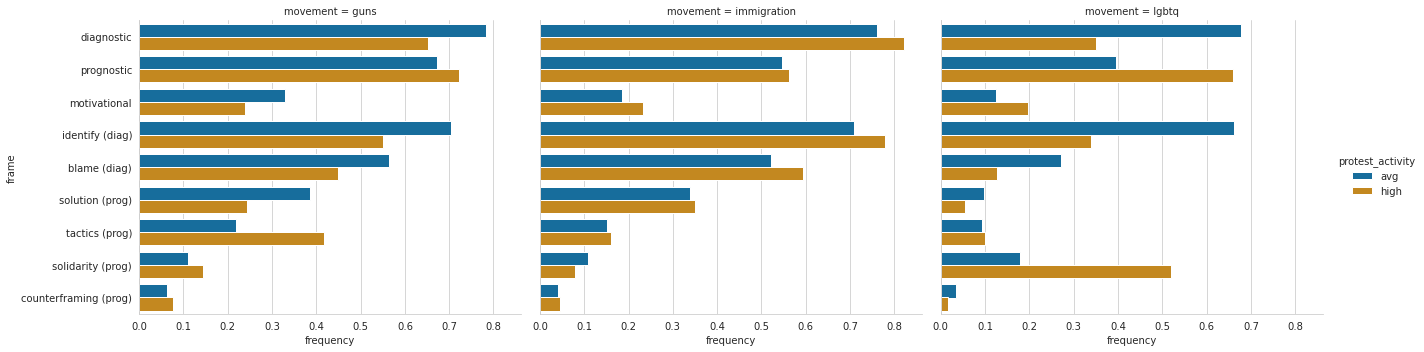

In [181]:
df_act = df_rel[['movement','stance','protest_activity']+all_frames].groupby(['movement','protest_activity','stance']).agg('mean').reset_index()
df_act = df_act[df_act['stance']=='pro']
df_act = df_act.drop(columns='stance')
df_act = pd.melt(df_act,id_vars=['movement','protest_activity'])
df_act.columns=['movement','protest_activity','frame','frequency']
sns.catplot(x='frequency',y='frame',hue='protest_activity',col='movement',data=df_act,kind='bar',aspect=1.25) 
# These plots show frames in the pro stance
# A lot of variation across movements
# More motivational framing in high activity period for immigration and LGBTQ, but not guns
# Less diagnostic fframing in high activity period for guns and LGBTQ, but not immigration
# More prognostic framing in high activity period for all movements, but the frame-element classifier suggests different aspects of prognostic framing are used across movements. 
# Guns: lots more tactics and solidarity, lot less solutions
# Immigration: a little more solution and tactics, a little less solidarity
# LGBTQ: lots more solidarity, less solution

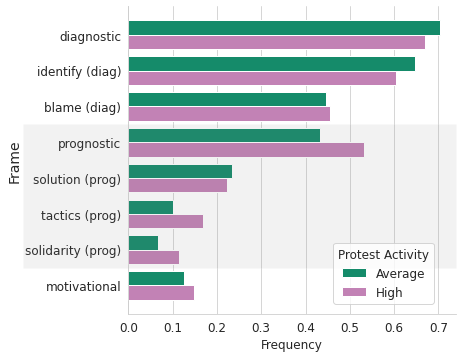

In [181]:
#Combined result across movements and stances
frame_order = ['diagnostic','identify (diag)','blame (diag)',
              'prognostic','solution (prog)','tactics (prog)','solidarity (prog)','motivational']
df_act = df_rel[['protest_activity']+macro_frames+frame_elem_for_analysis].groupby(['protest_activity']).agg('mean').reset_index()
df_act = pd.melt(df_act,id_vars=['protest_activity'])
df_act.columns=['protest_activity','frame','frequency']
g = sns.catplot(x='frequency',y='frame',hue='protest_activity',data=df_act,kind='bar',aspect=1.25,palette=[pal[2],pal[4]],order=frame_order,legend=False) 
#Overall trend: Less diagnostic, more prognostic, more motivational framing in periods of high protest activity

ax = g.axes[0,0]

ax.set_xlabel('Frequency',fontsize=12)
ax.set_ylabel('Frame',fontsize=14)
ax.axhspan(2.5,6.5,facecolor='gray',alpha=0.1,clip_on=False,xmin=-.32,xmax=1)

ax.tick_params(axis='both', which='major', labelsize=12)

L0 = ax.legend(bbox_to_anchor=(.95,0.25),fontsize=12,title='Protest Activity',title_fontsize=12)
#L0.set_title('Protest Activity',size=12)
L0.get_texts()[0].set_text('Average')
L0.get_texts()[1].set_text('High')
plt.savefig(os.path.join(results_dir,'protest_activity_all_frames.pdf'),bbox_inches='tight')


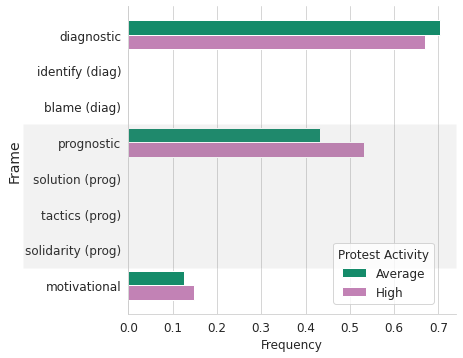

In [180]:
#Combined result across movements and stances
frame_order = ['diagnostic','identify (diag)','blame (diag)',
              'prognostic','solution (prog)','tactics (prog)','solidarity (prog)','motivational']
df_act = df_rel[['protest_activity']+macro_frames].groupby(['protest_activity']).agg('mean').reset_index()
df_act = pd.melt(df_act,id_vars=['protest_activity'])
df_act.columns=['protest_activity','frame','frequency']
g = sns.catplot(x='frequency',y='frame',hue='protest_activity',data=df_act,kind='bar',aspect=1.25,palette=[pal[2],pal[4]],order=frame_order,legend=False) 
#Overall trend: Less diagnostic, more prognostic, more motivational framing in periods of high protest activity

ax = g.axes[0,0]

ax.set_xlabel('Frequency',fontsize=12)
ax.set_ylabel('Frame',fontsize=14)
ax.axhspan(2.5,6.5,facecolor='gray',alpha=0.1,clip_on=False,xmin=-.32,xmax=1)

ax.tick_params(axis='both', which='major', labelsize=12)

L0 = ax.legend(bbox_to_anchor=(.95,0.25),fontsize=12,title='Protest Activity',title_fontsize=12)
#L0.set_title('Protest Activity',size=12)
L0.get_texts()[0].set_text('Average')
L0.get_texts()[1].set_text('High')
plt.savefig(os.path.join(results_dir,'protest_activity_macro_frames.pdf'),bbox_inches='tight')

# Analysis across tweet types (intended audiences)


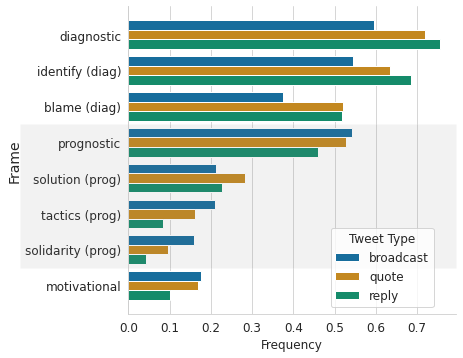

In [192]:
frame_order = ['diagnostic','identify (diag)','blame (diag)',
              'prognostic','solution (prog)','tactics (prog)','solidarity (prog)','motivational']

df_rel['tweet_category'] = df_rel['audience'].replace({'mention':'broadcast'})
df_sub = df_rel[['tweet_category']+macro_frames+frame_elements].groupby(['tweet_category']).agg('mean').reset_index()
df_sub = pd.melt(df_sub,id_vars=['tweet_category'])
df_sub.columns=['tweet_category','frame','frequency']
g=sns.catplot(x='frequency',y='frame',hue='tweet_category',data=df_sub,kind='bar',aspect=1.25,order=frame_order,legend=False) 
#Overall aggregated results in relevant tweets
# Diagnostic: most common in quotes and replies, much less common in broadcasts (both for problem ID and blame)
# Prognostic & Motivational: most common in broadcasts and quotes, least common in replies
# Solutions: most common in quotes, similar rates in broadcast and replies
# Tactics and solidarity: most common in broadcast, then quotes, then replies
# Counterframing: most common in replies

ax = g.axes[0,0]

ax.set_xlabel('Frequency',fontsize=12)
ax.set_ylabel('Frame',fontsize=14)
ax.axhspan(2.5,6.5,facecolor='gray',alpha=0.1,clip_on=False,xmin=-.33,xmax=1)

ax.tick_params(axis='both', which='major', labelsize=12)

L0 = ax.legend(bbox_to_anchor=(.95,.3),fontsize=12,title='Tweet Type',title_fontsize=12)
# L0.get_texts()[0].set_text('Average')
# L0.get_texts()[1].set_text('High')
plt.savefig(os.path.join(results_dir,'tweet_type_all_frames.pdf'),bbox_inches='tight')



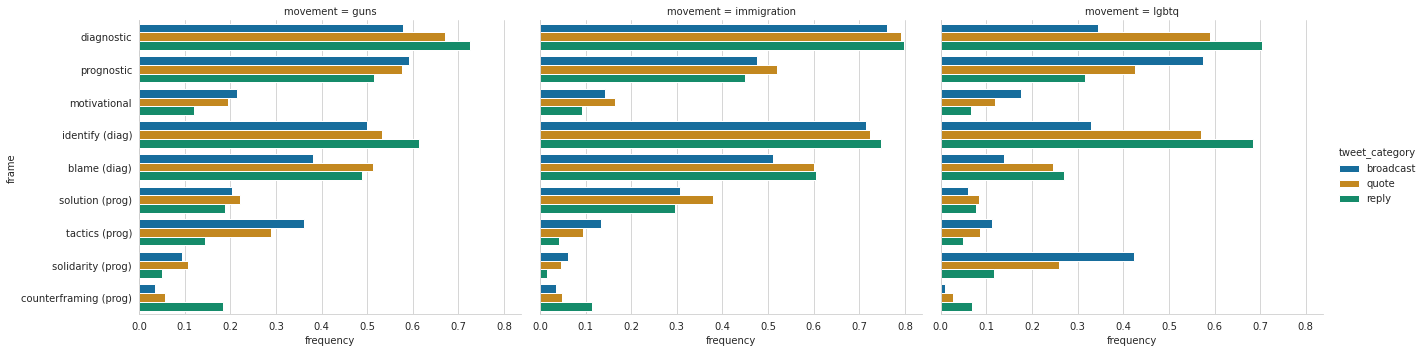

In [190]:
df_sub = df_rel[['movement','tweet_category']+all_frames].groupby(['movement','tweet_category']).agg('mean').reset_index()
df_sub = pd.melt(df_sub,id_vars=['movement','tweet_category'])
df_sub.columns=['movement','tweet_category','frame','frequency']
sns.catplot(x='frequency',y='frame',hue='tweet_category',col='movement',data=df_sub,kind='bar',aspect=1.25) 
#The pattern is remarkably stable across movements! 

# Comparison of SMO, journalists, everyone else (combined movements and stances)

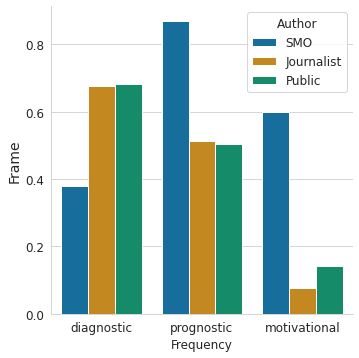

In [210]:
frame_order = ['diagnostic','identify (diag)','blame (diag)',
              'prognostic','solution (prog)','tactics (prog)','solidarity (prog)','motivational']


df_sub = df_rel[['stakeholder_group']+macro_frames].groupby(['stakeholder_group']).agg('mean').reset_index()
df_sub = pd.melt(df_sub,id_vars=['stakeholder_group'])
df_sub.columns=['stakeholder_group','frame','frequency']
g = sns.catplot(y='frequency',x='frame',hue='stakeholder_group',data=df_sub,kind='bar',aspect=1,legend=False,hue_order=['smo','journalist','other']) 
# SMOs engage in substantially less diagnostic framing, and way more prognostic/motivational framing (slightly for solutions, but substantially for tactics and solidarity)
# Relative to the public, journalists do more problem identification and discussion of tactics. 
# Relative to the public, journalists do less blame assignment, disucssions of solutions, and expressions of solidarity
#plt.title('All relevant tweets')


ax = g.axes[0,0]

ax.set_xlabel('Frequency',fontsize=12)
ax.set_ylabel('Frame',fontsize=14)
# ax.axhspan(2.5,6.5,facecolor='gray',alpha=0.1,clip_on=False,xmin=-.33,xmax=1)

ax.tick_params(axis='both', which='major', labelsize=12)

L0 = ax.legend(bbox_to_anchor=(1,1),fontsize=12,title='Author',title_fontsize=12)
L0.get_texts()[0].set_text('SMO')
L0.get_texts()[1].set_text('Journalist')
L0.get_texts()[2].set_text('Public')

plt.savefig(os.path.join(results_dir,'author_macro_frames.pdf'),bbox_inches='tight')



# Does this pattern hold just for the "pro" side? Yes! 

Text(0.5, 1.0, "Relevant 'pro' tweets")

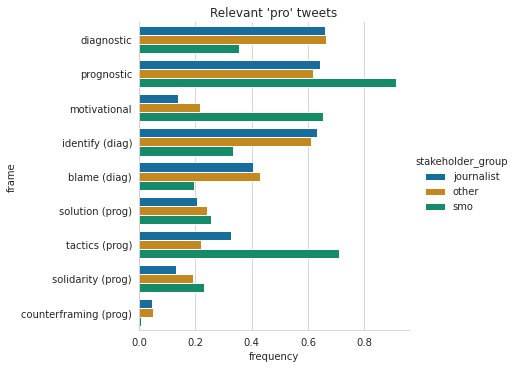

In [41]:
df_sub = df_rel[['stance','stakeholder_group']+all_frames].groupby(['stakeholder_group','stance']).agg('mean').reset_index()
df_sub = df_sub[df_sub['stance']=='pro']
df_sub = df_sub.drop(columns='stance')
df_sub = pd.melt(df_sub,id_vars=['stakeholder_group'])
df_sub.columns=['stakeholder_group','frame','frequency']
sns.catplot(x='frequency',y='frame',hue='stakeholder_group',data=df_sub,kind='bar',aspect=1.25) 
plt.title("Relevant 'pro' tweets")

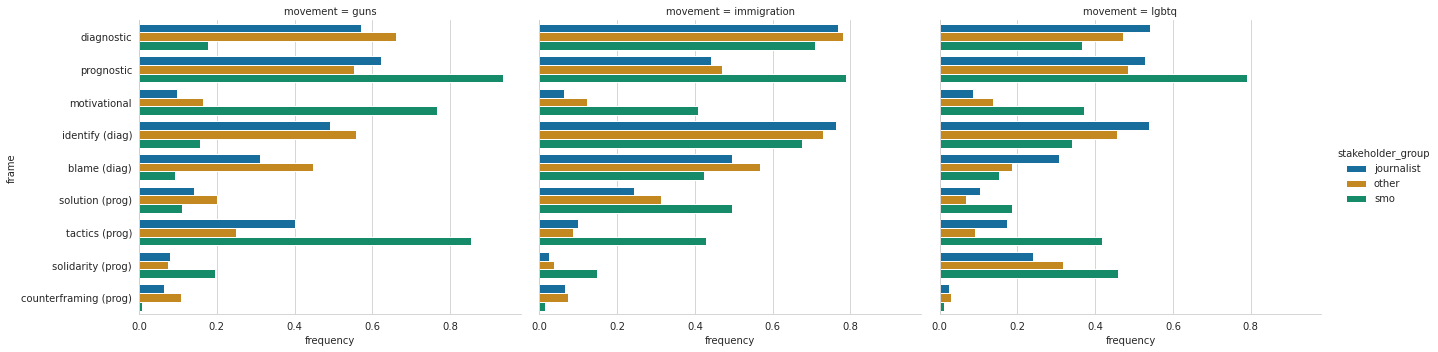

In [43]:
df_sub = df_rel[['movement','stakeholder_group']+all_frames].groupby(['movement','stakeholder_group']).agg('mean').reset_index()
df_sub = pd.melt(df_sub,id_vars=['movement','stakeholder_group'])
df_sub.columns=['movement','stakeholder_group','frame','frequency']
sns.catplot(x='frequency',y='frame',hue='stakeholder_group',col='movement',data=df_sub,kind='bar',aspect=1.25) 
# SMO: extent varies, but same patterns hold
# Journalists: less diagnostic framing than public for guns, more for lgbtq
# Journalists: more prognostic framing than public for guns and lgbtq, less for immigration
# Journalists: less motivational framing than public for all movements
# 

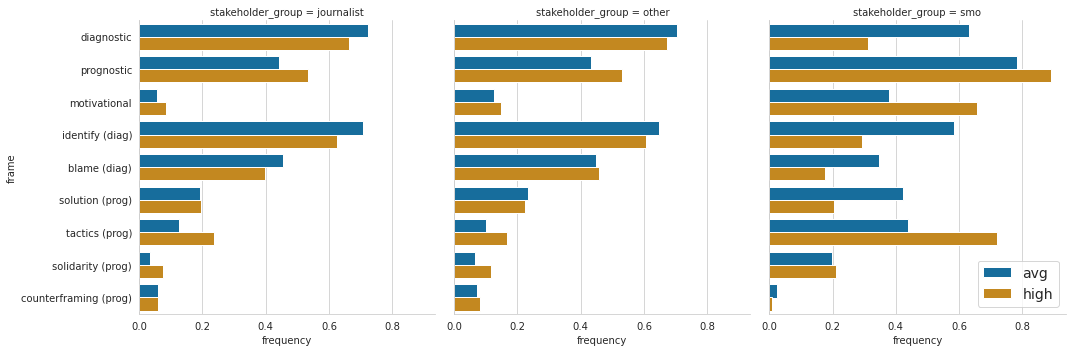

In [47]:
df_sub = df_rel[['protest_activity','stakeholder_group']+all_frames].groupby(['protest_activity','stakeholder_group']).agg('mean').reset_index()
df_sub = pd.melt(df_sub,id_vars=['protest_activity','stakeholder_group'])
df_sub.columns=['protest_activity','stakeholder_group','frame','frequency']
sns.catplot(x='frequency',y='frame',hue='protest_activity',col='stakeholder_group',data=df_sub,kind='bar',aspect=1,legend=False) 
# In periods of high protest activity, journalists 
#Overall trend: Less diagnostic, more prognostic, more motivational framing in periods of high protest activity
# The same overall trend holds for all stakeholder groups, but with much more dramatic differences between months for SMOs
plt.legend(fontsize=14)

In [200]:
# entropy in frame distribution between stakeholder groups within movements>

In [90]:
#Pairwise Entropy calculation with frequencies over these 9 categories
df_pro = df_rel[df_rel['stance']=='pro']
df_sub = df_rel[['movement','stakeholder_group']+all_frames].groupby(by=['movement','stakeholder_group']).agg('mean').reset_index()
frequency_vectors = df_sub[all_frames].values.tolist()
df_sub['subset'] = df_sub[['movement','stakeholder_group']].agg('-'.join, axis=1)
df_sub['vector'] = frequency_vectors
entropies = []
pairs = combinations(df_sub['subset'].unique(),2)
for movement in list(df_sub['movement'].unique()):
    for group_pair in combinations(df_sub['stakeholder_group'].unique(),2):
        group0,group1 = group_pair
        vec0 = df_sub[(df_sub['movement']==movement) & (df_sub['stakeholder_group']==group0)]['vector'].tolist()[0]
        vec1 = df_sub[(df_sub['movement']==movement) & (df_sub['stakeholder_group']==group1)]['vector'].tolist()[0]
        ent = entropy(vec0,vec1)
        entropies.append([movement,group_pair,ent])
df_ent = pd.DataFrame(entropies,columns=['movement','group pair','entropy'])

In [91]:
df_ent.sort_values(by='entropy')

,movement,group pair,entropy
3,immigration,"(journalist, other)",0.009305
6,lgbtq,"(journalist, other)",0.034881
0,guns,"(journalist, other)",0.037339
8,lgbtq,"(other, smo)",0.153405
5,immigration,"(other, smo)",0.154316
4,immigration,"(journalist, smo)",0.182030
7,lgbtq,"(journalist, smo)",0.190488
1,guns,"(journalist, smo)",0.514158
2,guns,"(other, smo)",0.674328


In [92]:
df_ent.groupby('movement').agg('mean').reset_index().sort_values(by='entropy')

,movement,entropy
1,immigration,0.115217
2,lgbtq,0.126258
0,guns,0.408608


In [93]:
df_ent.groupby('group pair').agg('mean').reset_index().sort_values(by='entropy')

,group pair,entropy
0,"(journalist, other)",0.027175
1,"(journalist, smo)",0.295559
2,"(other, smo)",0.327349


In [215]:
# get 1K frequency vectors based on mean of 10K randomly sampled from each of guns-anti,guns-pro,immigration-anti,immigration-pro
# Output structure: movement, stance, sample_id, vector
# for each sample id, calculate jensen-shannon divergence between all pairs
sample_size=100
num_samples=100
res = []

for i in range(num_samples):
    for movement in ['immigration','guns','lgbtq']:
        for group in ['smo','journalist','other']:
            df_sub = df_rel[(df_rel['movement']==movement) & (df_rel['stakeholder_group']==group)]
            df_sub = df_sub[['movement','stance']+macro_frames+frame_elem_for_analysis]
            df_sub = df_sub.sample(n=sample_size)
            vec = df_sub[macro_frames+frame_elem_for_analysis].mean().tolist()
            res.append((i,movement+'-'+group,vec))
res = pd.DataFrame(res,columns=['sample_id','movement-group','vector'])

In [224]:
entropies = []

for i in range(num_samples):
    res_sub = res[res['sample_id']==i]
    for pair in combinations(res_sub['movement-group'],2):
        vec0 = res_sub[res_sub['movement-group']==pair[0]]['vector'].tolist()[0]
        vec1 = res_sub[res_sub['movement-group']==pair[1]]['vector'].tolist()[0]
        vec0 = [x+.000001 for x in vec0]
        vec1 = [x+.000001 for x in vec1]
        ent = entropy(vec0,vec1)
        entropies.append((i,pair,ent))
entropies = pd.DataFrame(entropies,columns=['sample_id','movement-group','entropy'])
entropies_avg = entropies.groupby(by=['movement-group'])['entropy'].agg(['mean','sem']).reset_index() 
entropies_avg['ci'] = 1.96*entropies_avg['sem']
entropies_avg['ci_lower'] = entropies_avg['mean'] - entropies_avg['ci']
entropies_avg['ci_upper'] = entropies_avg['mean'] + entropies_avg['ci']

In [228]:
entropies_avg.sort_values(by='mean')

,movement-group,mean,sem,ci,ci_lower,ci_upper
15,"(immigration-journalist, immigration-other)",0.024481,0.001896,0.003716,0.020765,0.028197
0,"(guns-journalist, guns-other)",0.051345,0.002405,0.004714,0.046630,0.056059
33,"(lgbtq-journalist, lgbtq-other)",0.061886,0.003509,0.006878,0.055008,0.068765
26,"(immigration-smo, guns-other)",0.062972,0.002663,0.005219,0.057753,0.068191
20,"(immigration-other, guns-other)",0.063814,0.002678,0.005248,0.058566,0.069063
4,"(guns-other, lgbtq-journalist)",0.073004,0.002590,0.005077,0.067927,0.078081
13,"(immigration-journalist, guns-other)",0.073135,0.002806,0.005501,0.067634,0.078636
1,"(guns-journalist, lgbtq-journalist)",0.085026,0.003007,0.005894,0.079133,0.090920
25,"(immigration-smo, guns-journalist)",0.106799,0.003334,0.006535,0.100265,0.113334
16,"(immigration-journalist, lgbtq-journalist)",0.133480,0.003846,0.007538,0.125943,0.141018


In [227]:
res.to_csv(os.path.join(results_dir,'bootstrap_frame_vectors_stakeholders.tsv'),sep='\t')
entropies_avg.to_csv(os.path.join(results_dir,'frame_vector_entropies_stakeholders.tsv'),sep='\t')

# Time Series Plots

In [7]:
import matplotlib.dates as mdates

In [8]:
df_rel.columns
df_rel['created_at_dt']= pd.to_datetime(df_rel['created_at'])
df_rel['date']= df_rel['created_at_dt'].dt.date
# convert created_at to date pd.to_datetime(df_rel['created_at'])

In [17]:
df_rel['created_at_dt']= pd.to_datetime(df_rel['created_at'])
df_rel['date']= df_rel['created_at_dt'].dt.date
cols_to_keep = ['movement','protest_activity','date','stakeholder_group'] + macro_frames

df_sub = df_rel[cols_to_keep]
df_date_sums = df_sub.groupby(by=['movement','protest_activity','date']).agg('sum').reset_index()
df_date_norm = df_sub.groupby(by=['movement','protest_activity','date']).agg('mean').reset_index()

df_date_sums['agg'] = 'sum'
df_date_norm['agg'] = 'norm'

# df_date_sums = pd.melt(df_date_sums,id_vars=['movement','protest_activity','date'])
# df_date_norm = pd.melt(df_date_norm,id_vars=['movement','protest_activity','date'])

df_date = pd.concat([df_date_sums,df_date_norm])

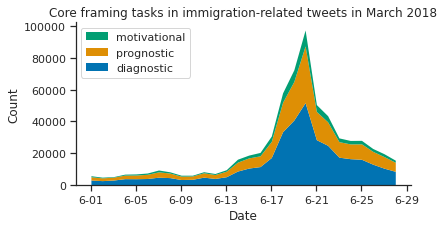

In [222]:
f, ax = plt.subplots(figsize=(6, 3))
sns.despine(f)
df_sub = df_date_sums[(df_date_sums['movement']=='immigration') & (df_date_sums['protest_activity']=='high')]
df_sub.plot.area(x='date',figsize=(6,3),linewidth=0,ax=ax,legend=False)
#plt.xticks(rotation=20)
#plt.axvline(datetime.datetime(2018, 3, 24),color='maroon')
#plt.axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white')
plt.ylabel('Count')
plt.xlabel('Date')
plt.title("Core framing tasks in immigration-related tweets in March 2018")
plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%d'))

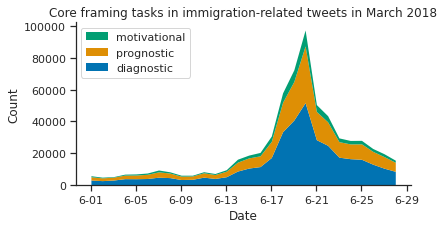

In [164]:
f, ax = plt.subplots(figsize=(6, 3))
sns.despine(f)
df_sub = df_date_sums[(df_date_sums['movement']=='immigration') & (df_date_sums['protest_activity']=='high')]
df_sub.plot.area(x='date',figsize=(6,3),linewidth=0,ax=ax,legend=False)
#plt.xticks(rotation=20)
#plt.axvline(datetime.datetime(2018, 3, 24),color='maroon')
#plt.axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white')
plt.ylabel('Count')
plt.xlabel('Date')
plt.title("Core framing tasks in immigration-related tweets in March 2018")
plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%d'))


plt.savefig('/home/juliame/social-movements/results/timeseries_immigration_sum.pdf',bbox_inches='tight')



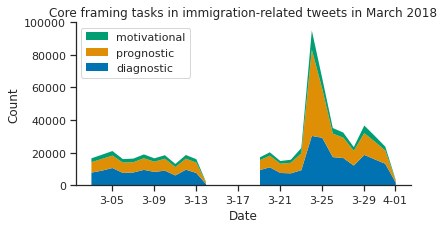

In [165]:
f, ax = plt.subplots(figsize=(6, 3))
sns.despine(f)
df_sub = df_date_sums[(df_date_norm['movement']=='guns') & (df_date_norm['protest_activity']=='high')]
df_sub.plot.area(x='date',figsize=(6,3),linewidth=0,ax=ax,legend=False)
#plt.xticks(rotation=20)
#plt.axvline(datetime.datetime(2018, 3, 24),color='maroon')
plt.axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white')
plt.ylabel('Count')
plt.xlabel('Date')
plt.title("Core framing tasks in immigration-related tweets in March 2018")
plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%d'))


#plt.savefig('/home/juliame/social-movements/results/timeseries_immigration_sum.pdf',bbox_inches='tight')


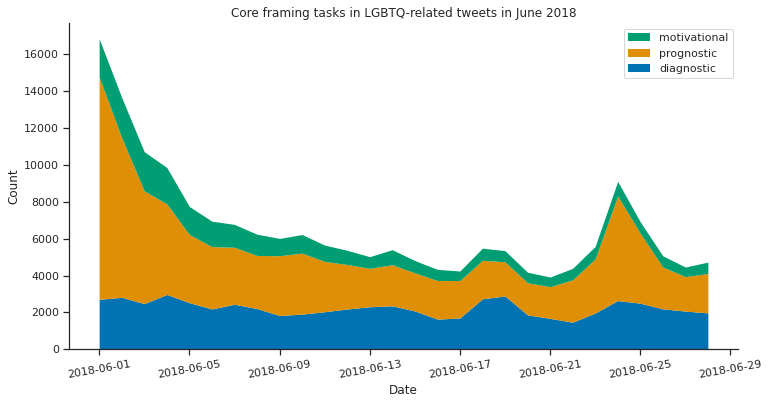

In [106]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
df_sub = df_date_sums[(df_date_sums['movement']=='lgbtq') & (df_date_sums['protest_activity']=='high')]
df_sub.plot.area(x='date',figsize=(12,6),linewidth=0,ax=ax,legend=False)
plt.xticks(rotation=10)
#plt.axvline(datetime.datetime(2018, 3, 24),color='black')
#plt.axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white')
plt.ylabel('Count')
plt.xlabel('Date')
plt.title("Core framing tasks in LGBTQ-related tweets in June 2018")
plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

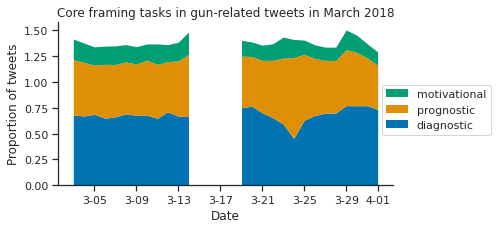

In [182]:
f, ax = plt.subplots(figsize=(6, 3))
sns.despine(f)
df_sub = df_date_norm[(df_date_norm['movement']=='guns') & (df_date_norm['protest_activity']=='high')]
df_sub.plot.area(x='date',figsize=(6,3),linewidth=0,ax=ax,legend=False)
#plt.xticks(rotation=20)
#plt.axvline(datetime.datetime(2018, 3, 24),color='maroon')
plt.axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white')
plt.ylabel('Proportion of tweets')
plt.xlabel('Date')
plt.title("Core framing tasks in gun-related tweets in March 2018")
plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(.95,.65))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%d'))


plt.savefig('/home/juliame/social-movements/results/timeseries_guns_norm.pdf',bbox_inches='tight')

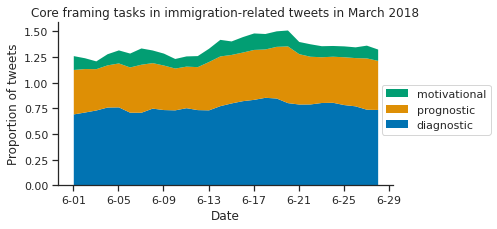

In [183]:
f, ax = plt.subplots(figsize=(6, 3))
sns.despine(f)
df_sub = df_date_norm[(df_date_norm['movement']=='immigration') & (df_date_norm['protest_activity']=='high')]
df_sub.plot.area(x='date',figsize=(6,3),linewidth=0,ax=ax,legend=False)
#plt.xticks(rotation=20)
#plt.axvline(datetime.datetime(2018, 3, 24),color='maroon')
plt.ylabel('Proportion of tweets')
plt.xlabel('Date')
plt.title("Core framing tasks in immigration-related tweets in March 2018")
plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(.95,.65))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%d'))


plt.savefig('/home/juliame/social-movements/results/timeseries_immigration_norm.pdf',bbox_inches='tight')

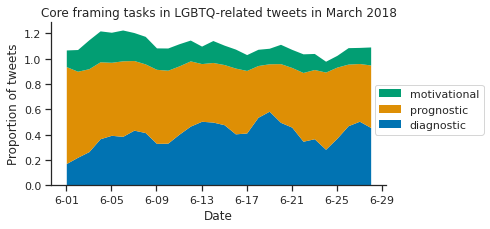

In [184]:
f, ax = plt.subplots(figsize=(6, 3))
sns.despine(f)
df_sub = df_date_norm[(df_date_norm['movement']=='lgbtq') & (df_date_norm['protest_activity']=='high')]
df_sub.plot.area(x='date',figsize=(6,3),linewidth=0,ax=ax,legend=False)
#plt.xticks(rotation=20)
#plt.axvline(datetime.datetime(2018, 3, 24),color='maroon')
plt.ylabel('Proportion of tweets')
plt.xlabel('Date')
plt.title("Core framing tasks in LGBTQ-related tweets in March 2018")
plt.legend(bbox_to_anchor=(0,1))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(.95,.65))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%d'))


plt.savefig('/home/juliame/social-movements/results/timeseries_lgbtq_norm.pdf',bbox_inches='tight')

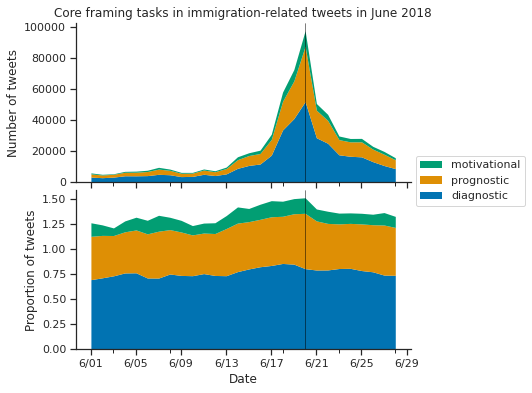

In [259]:
fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True,
                        figsize=(6,6))
sns.despine()
df_sub = df_date[(df_date['movement']=='immigration') & (df_date['protest_activity']=='high')]
df_sub_sum = df_sub[df_sub['agg']=='sum']
df_sub_norm = df_sub[df_sub['agg']=='norm']

df_sub_sum.plot.area(ax = axes[0],x='date',linewidth=0,legend=False)
df_sub_norm.plot.area(ax = axes[1],x='date',linewidth=0,legend=False)

#plt.xticks(rotation=20)
#plt.axvline(datetime.datetime(2018, 3, 24),color='maroon')
axes[0].set_ylabel('Number of tweets')
axes[1].set_ylabel('Proportion of tweets')
axes[1].set_xlabel('Date')
axes[0].set_title("Core framing tasks in immigration-related tweets in June 2018")
plt.subplots_adjust(hspace=0.05)  # You can adjust the value as needed

axes[0].axvline(datetime.datetime(2018, 6, 20),color='black',lw=.5)
axes[1].axvline(datetime.datetime(2018, 6, 20),color='black',lw=.5)


handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1],bbox_to_anchor=(1,0.2))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))

plt.savefig('/home/juliame/social-movements/results/timeseries_immigration.pdf',bbox_inches='tight')

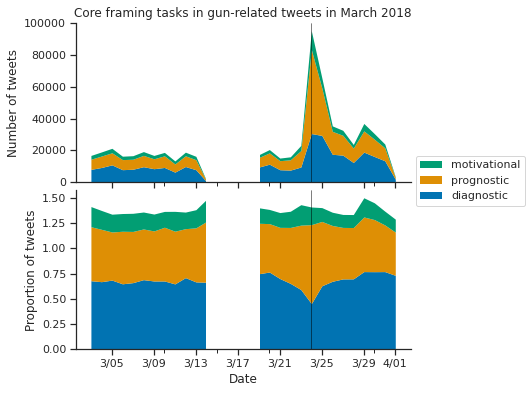

In [260]:
fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True,
                        figsize=(6,6))
sns.despine()
df_sub = df_date[(df_date['movement']=='guns') & (df_date['protest_activity']=='high')]
df_sub_sum = df_sub[df_sub['agg']=='sum']
df_sub_norm = df_sub[df_sub['agg']=='norm']

df_sub_sum.plot.area(ax = axes[0],x='date',linewidth=0,legend=False)
df_sub_norm.plot.area(ax = axes[1],x='date',linewidth=0,legend=False)

#plt.xticks(rotation=20)
#plt.axvline(datetime.datetime(2018, 3, 24),color='maroon')
axes[0].set_ylabel('Number of tweets')
axes[1].set_ylabel('Proportion of tweets')
axes[1].set_xlabel('Date')
axes[0].set_title("Core framing tasks in gun-related tweets in March 2018")
plt.subplots_adjust(hspace=0.05)  # You can adjust the value as needed

axes[0].axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white')
axes[1].axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white')


axes[0].axvline(datetime.datetime(2018, 3, 24),color='black',lw=.5)
axes[1].axvline(datetime.datetime(2018, 3, 24),color='black',lw=.5)


handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1],bbox_to_anchor=(1,0.2))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))

plt.savefig('/home/juliame/social-movements/results/timeseries_guns.pdf',bbox_inches='tight')

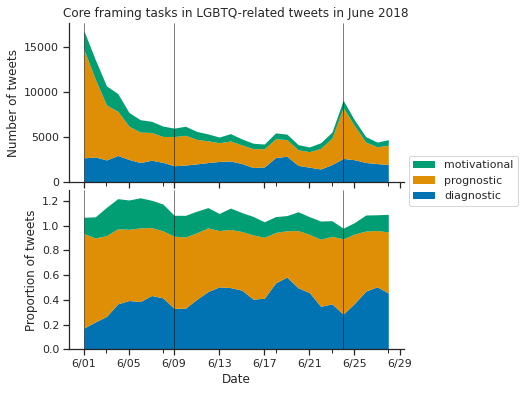

In [261]:
fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True,
                        figsize=(6,6))
sns.despine()
df_sub = df_date[(df_date['movement']=='lgbtq') & (df_date['protest_activity']=='high')]
df_sub_sum = df_sub[df_sub['agg']=='sum']
df_sub_norm = df_sub[df_sub['agg']=='norm']

df_sub_sum.plot.area(ax = axes[0],x='date',linewidth=0,legend=False)
df_sub_norm.plot.area(ax = axes[1],x='date',linewidth=0,legend=False)

#plt.xticks(rotation=20)
#plt.axvline(datetime.datetime(2018, 3, 24),color='maroon')
axes[0].set_ylabel('Number of tweets')
axes[1].set_ylabel('Proportion of tweets')
axes[1].set_xlabel('Date')
axes[0].set_title("Core framing tasks in LGBTQ-related tweets in June 2018")
plt.subplots_adjust(hspace=0.05)  # You can adjust the value as needed


axes[0].axvline(datetime.datetime(2018, 6, 1),color='black',lw=.5)
axes[1].axvline(datetime.datetime(2018, 6, 1),color='black',lw=.5)


axes[0].axvline(datetime.datetime(2018, 6, 9),color='black',lw=.5)
axes[1].axvline(datetime.datetime(2018, 6, 9),color='black',lw=.5)


axes[0].axvline(datetime.datetime(2018, 6, 24),color='black',lw=.5)
axes[1].axvline(datetime.datetime(2018, 6, 24),color='black',lw=.5)


handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1],bbox_to_anchor=(1,0.2))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))


plt.savefig('/home/juliame/social-movements/results/timeseries_lgbtq.pdf',bbox_inches='tight')

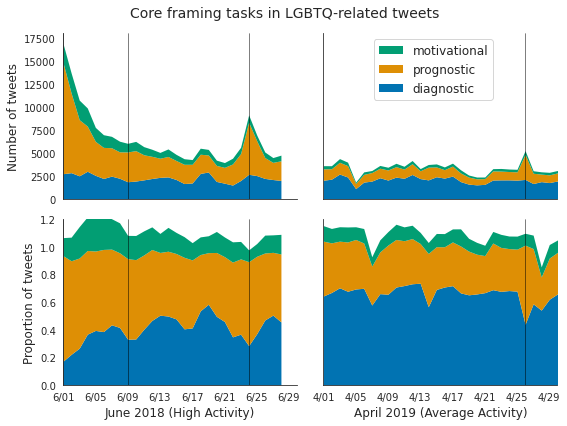

In [96]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         sharex='col',
                         sharey='row',
                        figsize=(8,6))
sns.despine()
df_sub = df_date[(df_date['movement']=='lgbtq')]
df_sub_sum_avg = df_sub[(df_sub['agg']=='sum') & (df_sub['protest_activity']=='avg')]
df_sub_norm_avg = df_sub[(df_sub['agg']=='norm') & (df_sub['protest_activity']=='avg')]

df_sub_sum_high = df_sub[(df_sub['agg']=='sum') & (df_sub['protest_activity']=='high')]
df_sub_norm_high = df_sub[(df_sub['agg']=='norm') & (df_sub['protest_activity']=='high')]

df_sub_sum_avg.plot.area(ax = axes[0,1],x='date',linewidth=0,legend=False)
df_sub_norm_avg.plot.area(ax = axes[1,1],x='date',linewidth=0,legend=False)
df_sub_sum_high.plot.area(ax = axes[0,0],x='date',linewidth=0,legend=False)
df_sub_norm_high.plot.area(ax = axes[1,0],x='date',linewidth=0,legend=False)

fig.suptitle("Core framing tasks in LGBTQ-related tweets",fontsize=14)
axes[0,0].set_ylabel('Number of tweets',fontsize=12)
axes[1,0].set_ylabel('Proportion of tweets',fontsize=12)
axes[1,1].set_xlabel('April 2019 (Average Activity)',fontsize=12)
axes[1,0].set_xlabel('June 2018 (High Activity)',fontsize=12)

axes[1,1].set_xlim(datetime.datetime(2019, 4, 1),datetime.datetime(2019, 4, 30))
axes[1,0].set_xlim(datetime.datetime(2018, 6, 1),datetime.datetime(2018, 6, 30))

axes[0,0].set_ylim((0,18000))
axes[1,0].set_ylim((0,1.2))
    
axes[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))
axes[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))

axes[0,0].axvline(datetime.datetime(2018, 6, 1),color='black',lw=.5)
axes[1,0].axvline(datetime.datetime(2018, 6, 1),color='black',lw=.5)

axes[0,0].axvline(datetime.datetime(2018, 6, 9),color='black',lw=.5)
axes[1,0].axvline(datetime.datetime(2018, 6, 9),color='black',lw=.5)

axes[0,0].axvline(datetime.datetime(2018, 6, 24),color='black',lw=.5)
axes[1,0].axvline(datetime.datetime(2018, 6, 24),color='black',lw=.5)

axes[0,1].axvline(datetime.datetime(2019, 4, 26),color='black',lw=.5)
axes[1,1].axvline(datetime.datetime(2019, 4, 26),color='black',lw=.5)

plt.tight_layout()



handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,1].legend(handles[::-1], labels[::-1],ncol=1,bbox_to_anchor=(.75,1),fontsize=12)

plt.savefig('/home/juliame/social-movements/results/timeseries_lgbtq_both_months.pdf',bbox_inches='tight')

In [103]:
df_date.columns

Index(['movement', 'protest_activity', 'date', 'diagnostic', 'prognostic',
       'motivational', 'agg'],
      dtype='object')

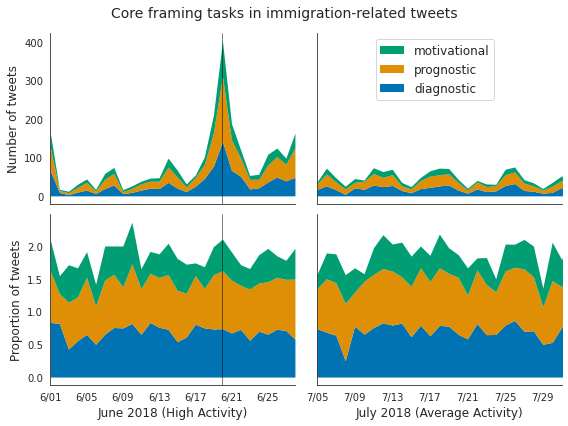

In [106]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         sharex='col',
                         sharey='row',
                        figsize=(8,6))
sns.despine()
df_sub = df_date[(df_date['movement']=='immigration') & (df_date['stakeholder_group']=='smo')]
df_sub_sum_avg = df_sub[(df_sub['agg']=='sum') & (df_sub['protest_activity']=='avg')]
df_sub_norm_avg = df_sub[(df_sub['agg']=='norm') & (df_sub['protest_activity']=='avg')]

df_sub_sum_high = df_sub[(df_sub['agg']=='sum') & (df_sub['protest_activity']=='high')]
df_sub_norm_high = df_sub[(df_sub['agg']=='norm') & (df_sub['protest_activity']=='high')]

df_sub_sum_avg.plot.area(ax = axes[0,1],x='date',linewidth=0,legend=False)
df_sub_norm_avg.plot.area(ax = axes[1,1],x='date',linewidth=0,legend=False)
df_sub_sum_high.plot.area(ax = axes[0,0],x='date',linewidth=0,legend=False)
df_sub_norm_high.plot.area(ax = axes[1,0],x='date',linewidth=0,legend=False)

fig.suptitle("Core framing tasks in immigration-related tweets",fontsize=14)
axes[0,0].set_ylabel('Number of tweets',fontsize=12)
axes[1,0].set_ylabel('Proportion of tweets',fontsize=12)
axes[1,1].set_xlabel('July 2018 (Average Activity)',fontsize=12)
axes[1,0].set_xlabel('June 2018 (High Activity)',fontsize=12)

axes[1,1].set_xlim(datetime.datetime(2018, 7, 5),datetime.datetime(2018, 7, 31))
axes[1,0].set_xlim(datetime.datetime(2018, 6, 1),datetime.datetime(2018, 6, 28))

# axes[0,0].set_ylim((0,100000))
# axes[1,0].set_ylim((0,1.5))
    
axes[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))
axes[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))

axes[0,0].axvline(datetime.datetime(2018, 6, 20),color='black',lw=.5)
axes[1,0].axvline(datetime.datetime(2018, 6, 20),color='black',lw=.5)

plt.tight_layout()



handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,1].legend(handles[::-1], labels[::-1],ncol=1,bbox_to_anchor=(.75,1),fontsize=12)

#plt.savefig('/home/juliame/social-movements/results/timeseries_immigration_both_months.pdf',bbox_inches='tight')

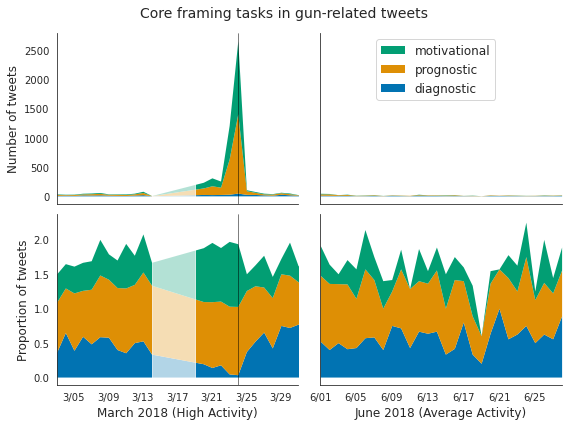

In [110]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         sharex='col',
                         sharey='row',
                        figsize=(8,6))
sns.despine()
df_sub = df_date[(df_date['movement']=='guns') & (df_date['stakeholder_group']=='smo')]
df_sub_sum_avg = df_sub[(df_sub['agg']=='sum') & (df_sub['protest_activity']=='avg')]
df_sub_norm_avg = df_sub[(df_sub['agg']=='norm') & (df_sub['protest_activity']=='avg')]

df_sub_sum_high = df_sub[(df_sub['agg']=='sum') & (df_sub['protest_activity']=='high')]
df_sub_norm_high = df_sub[(df_sub['agg']=='norm') & (df_sub['protest_activity']=='high')]

df_sub_sum_avg.plot.area(ax = axes[0,1],x='date',linewidth=0,legend=False)
df_sub_norm_avg.plot.area(ax = axes[1,1],x='date',linewidth=0,legend=False)
df_sub_sum_high.plot.area(ax = axes[0,0],x='date',linewidth=0,legend=False)
df_sub_norm_high.plot.area(ax = axes[1,0],x='date',linewidth=0,legend=False)

fig.suptitle("Core framing tasks in gun-related tweets",fontsize=14)
axes[0,0].set_ylabel('Number of tweets',fontsize=12)
axes[1,0].set_ylabel('Proportion of tweets',fontsize=12)
axes[1,1].set_xlabel('June 2018 (Average Activity)',fontsize=12)
axes[1,0].set_xlabel('March 2018 (High Activity)',fontsize=12)

axes[1,1].set_xlim(datetime.datetime(2018, 6, 1),datetime.datetime(2018, 6, 28))
axes[1,0].set_xlim(datetime.datetime(2018, 3, 3),datetime.datetime(2018, 3, 31))

axes[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))
axes[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))

axes[0,0].axvline(datetime.datetime(2018, 3, 24),color='black',lw=.5)
axes[1,0].axvline(datetime.datetime(2018, 3, 24),color='black',lw=.5)

plt.tight_layout()

# axes[0,0].set_ylim((0,100000))
# axes[1,0].set_ylim((0,1.5))

axes[0,0].axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white',alpha=0.7)
axes[1,0].axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white',alpha=0.7)

handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,1].legend(handles[::-1], labels[::-1],ncol=1,bbox_to_anchor=(.75,1),fontsize=12)

plt.savefig('/home/juliame/social-movements/results/timeseries_guns_both_months.pdf',bbox_inches='tight')

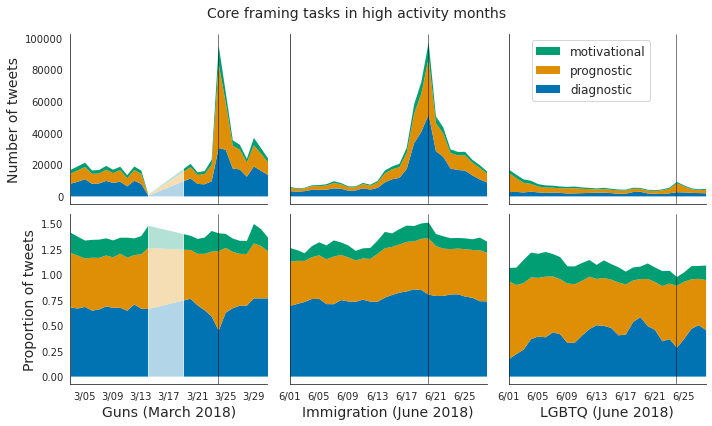

In [29]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         sharex='col',
                         sharey='row',
                        figsize=(10,6))
sns.despine()

df_sub = df_date[df_date['protest_activity']=='high']

df_sub_sum_lgbtq = df_sub[(df_sub['agg']=='sum') & (df_sub['movement']=='lgbtq')]
df_sub_norm_lgbtq = df_sub[(df_sub['agg']=='norm') & (df_sub['movement']=='lgbtq')]

df_sub_sum_guns = df_sub[(df_sub['agg']=='sum') & (df_sub['movement']=='guns')]
df_sub_norm_guns = df_sub[(df_sub['agg']=='norm') & (df_sub['movement']=='guns')]

df_sub_sum_immigration = df_sub[(df_sub['agg']=='sum') & (df_sub['movement']=='immigration')]
df_sub_norm_immigration = df_sub[(df_sub['agg']=='norm') & (df_sub['movement']=='immigration')]


df_sub_sum_guns.plot.area(ax = axes[0,0],x='date',linewidth=0,legend=False)
df_sub_sum_immigration.plot.area(ax = axes[0,1],x='date',linewidth=0,legend=False)
df_sub_sum_lgbtq.plot.area(ax = axes[0,2],x='date',linewidth=0,legend=False)

df_sub_norm_guns.plot.area(ax = axes[1,0],x='date',linewidth=0,legend=False)
df_sub_norm_immigration.plot.area(ax = axes[1,1],x='date',linewidth=0,legend=False)
df_sub_norm_lgbtq.plot.area(ax = axes[1,2],x='date',linewidth=0,legend=False)


fig.suptitle("Core framing tasks in high activity months",fontsize=14)
axes[0,0].set_ylabel('Number of tweets',fontsize=14)
axes[1,0].set_ylabel('Proportion of tweets',fontsize=14)

axes[1,0].set_xlabel('Guns (March 2018)',fontsize=14)
axes[1,1].set_xlabel('Immigration (June 2018)',fontsize=14)
axes[1,2].set_xlabel('LGBTQ (June 2018)',fontsize=14)

axes[1,0].set_xlim(datetime.datetime(2018, 3, 3),datetime.datetime(2018, 3, 31))
axes[1,1].set_xlim(datetime.datetime(2018, 6, 1),datetime.datetime(2018, 6, 28))
axes[1,2].set_xlim(datetime.datetime(2018, 6, 1),datetime.datetime(2018, 6, 28))

# axes[0,0].set_ylim((0,18000))
# axes[1,0].set_ylim((0,1.2))
    
axes[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))
axes[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))
axes[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))



axes[0,0].axvline(datetime.datetime(2018, 3, 24),color='black',lw=.5)
axes[1,0].axvline(datetime.datetime(2018, 3, 24),color='black',lw=.5)

axes[0,1].axvline(datetime.datetime(2018, 6, 20),color='black',lw=.5)
axes[1,1].axvline(datetime.datetime(2018, 6, 20),color='black',lw=.5)

axes[0,2].axvline(datetime.datetime(2018, 6, 24),color='black',lw=.5)
axes[1,2].axvline(datetime.datetime(2018, 6, 24),color='black',lw=.5)

# axes[0,1].axvline(datetime.datetime(2019, 4, 26),color='black',lw=.5)
# axes[1,1].axvline(datetime.datetime(2019, 4, 26),color='black',lw=.5)


axes[0,0].axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white',alpha=0.7)
axes[1,0].axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white',alpha=0.7)


plt.tight_layout()



handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,2].legend(handles[::-1], labels[::-1],ncol=1,bbox_to_anchor=(.75,1),fontsize=12)

plt.savefig('/home/juliame/social-movements/results/timeseries_high_all_issues.pdf',bbox_inches='tight')

In [30]:
df_rel['created_at_dt']= pd.to_datetime(df_rel['created_at'])
df_rel['date']= df_rel['created_at_dt'].dt.date
cols_to_keep = ['movement','protest_activity','date','stakeholder_group'] + macro_frames

df_sub = df_rel[cols_to_keep]
df_date_sums_by_stakeholder = df_sub.groupby(by=['movement','protest_activity','stakeholder_group','date']).agg('sum').reset_index()
df_date_norm_by_stakeholder = df_sub.groupby(by=['movement','protest_activity','stakeholder_group','date']).agg('mean').reset_index()

df_date_sums_by_stakeholder['agg'] = 'sum'
df_date_norm_by_stakeholder['agg'] = 'norm'

df_date_by_stakeholder = pd.concat([df_date_sums_by_stakeholder,df_date_norm_by_stakeholder])


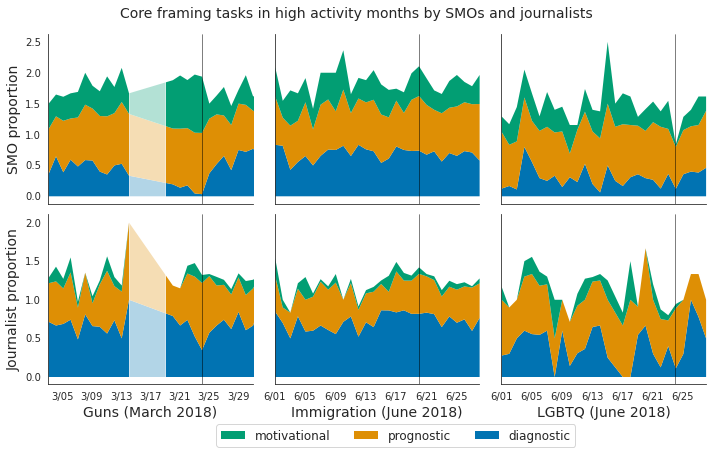

In [47]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         sharex='col',
                         sharey='row',
                        figsize=(10,6))
sns.despine()

df_sub_smo = df_date_by_stakeholder[(df_date_by_stakeholder['protest_activity']=='high') & (df_date_by_stakeholder['stakeholder_group']=='smo')]
df_sub_journo = df_date_by_stakeholder[(df_date_by_stakeholder['protest_activity']=='high') & (df_date_by_stakeholder['stakeholder_group']=='journalist')]


df_sub_smo_lgbtq = df_sub_smo[(df_sub_smo['agg']=='norm') & (df_sub_smo['movement']=='lgbtq')]
df_sub_journo_lgbtq = df_sub_journo[(df_sub_journo['agg']=='norm') & (df_sub_journo['movement']=='lgbtq')]

df_sub_smo_guns = df_sub_smo[(df_sub_smo['agg']=='norm') & (df_sub_smo['movement']=='guns')]
df_sub_journo_guns = df_sub_journo[(df_sub_journo['agg']=='norm') & (df_sub_journo['movement']=='guns')]

df_sub_smo_immigration = df_sub_smo[(df_sub_smo['agg']=='norm') & (df_sub_smo['movement']=='immigration')]
df_sub_journo_immigration = df_sub_journo[(df_sub_journo['agg']=='norm') & (df_sub_journo['movement']=='immigration')]


df_sub_smo_guns.plot.area(ax = axes[0,0],x='date',linewidth=0,legend=False)
df_sub_smo_immigration.plot.area(ax = axes[0,1],x='date',linewidth=0,legend=False)
df_sub_smo_lgbtq.plot.area(ax = axes[0,2],x='date',linewidth=0,legend=False)

df_sub_journo_guns.plot.area(ax = axes[1,0],x='date',linewidth=0,legend=False)
df_sub_journo_immigration.plot.area(ax = axes[1,1],x='date',linewidth=0,legend=False)
df_sub_journo_lgbtq.plot.area(ax = axes[1,2],x='date',linewidth=0,legend=False)


fig.suptitle("Core framing tasks in high activity months by SMOs and journalists",fontsize=14)
axes[0,0].set_ylabel('SMO proportion',fontsize=14)
axes[1,0].set_ylabel('Journalist proportion',fontsize=14)

axes[1,0].set_xlabel('Guns (March 2018)',fontsize=14)
axes[1,1].set_xlabel('Immigration (June 2018)',fontsize=14)
axes[1,2].set_xlabel('LGBTQ (June 2018)',fontsize=14)

axes[1,0].set_xlim(datetime.datetime(2018, 3, 3),datetime.datetime(2018, 3, 31))
axes[1,1].set_xlim(datetime.datetime(2018, 6, 1),datetime.datetime(2018, 6, 28))
axes[1,2].set_xlim(datetime.datetime(2018, 6, 1),datetime.datetime(2018, 6, 28))

# axes[0,0].set_ylim((0,18000))
# axes[1,0].set_ylim((0,1.2))
    
axes[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))
axes[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))
axes[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d'))



axes[0,0].axvline(datetime.datetime(2018, 3, 24),color='black',lw=.5)
axes[1,0].axvline(datetime.datetime(2018, 3, 24),color='black',lw=.5)

axes[0,1].axvline(datetime.datetime(2018, 6, 20),color='black',lw=.5)
axes[1,1].axvline(datetime.datetime(2018, 6, 20),color='black',lw=.5)

axes[0,2].axvline(datetime.datetime(2018, 6, 24),color='black',lw=.5)
axes[1,2].axvline(datetime.datetime(2018, 6, 24),color='black',lw=.5)

# axes[0,1].axvline(datetime.datetime(2019, 4, 26),color='black',lw=.5)
# axes[1,1].axvline(datetime.datetime(2019, 4, 26),color='black',lw=.5)


axes[0,0].axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white',alpha=0.7)
axes[1,0].axvspan(datetime.datetime(2018, 3, 14),datetime.datetime(2018, 3, 19),color='white',alpha=0.7)


plt.tight_layout()



handles, labels = axes[0,0].get_legend_handles_labels()
axes[1,1].legend(handles[::-1], labels[::-1],ncol=3,bbox_to_anchor=(1.5,-.2),fontsize=12)

plt.savefig('/home/juliame/social-movements/results/timeseries_high_stakeholder_group.pdf',bbox_inches='tight')

In [34]:
df_sub_journo

,movement,protest_activity,stakeholder_group,date,diagnostic,prognostic,motivational,agg
84,guns,high,journalist,2018-03-03,10.000000,7.000000,1.000000,sum
85,guns,high,journalist,2018-03-04,14.000000,12.000000,4.000000,sum
86,guns,high,journalist,2018-03-05,33.000000,22.000000,6.000000,sum
87,guns,high,journalist,2018-03-06,23.000000,19.000000,6.000000,sum
88,guns,high,journalist,2018-03-07,19.000000,16.000000,3.000000,sum
...,...,...,...,...,...,...,...,...
442,lgbtq,high,journalist,2018-06-24,0.111111,0.777778,0.055556,norm
443,lgbtq,high,journalist,2018-06-25,0.300000,0.700000,0.000000,norm
444,lgbtq,high,journalist,2018-06-26,1.000000,0.333333,0.000000,norm
445,lgbtq,high,journalist,2018-06-27,0.777778,0.555556,0.000000,norm
